In [1]:
# Tutorial code of 1-D GAN
# http://blog.naver.com/atelierjpro/220984758512
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import tensorflow as tf


In [2]:
gpu_config = tf.ConfigProto(device_count={'GPU':1})  # only use GPU no.1 change this!
gpu_config.gpu_options.allow_growth = True # only use required resource(memory)
gpu_config.gpu_options.per_process_gpu_memory_fraction = 0.5 # restrict to 50%

In [8]:
sess = tf.InteractiveSession(config=gpu_config)
# sess = tf.Session(config=gpu_config)
mu = 0.8
sigma=0.1
num_bins = 100
num_samples = 1000000

class GenerativeNetwork:
    dim_z=1
    dim_g=1
    n_hidden = 10
    learning_rate = 1e-1
    
    def __init__(self):
        
        # rand_uni for initialization of W,b / Not for input
        rand_uni = tf.random_uniform_initializer(-1e1,1e1)
        
        self.z_input = tf.placeholder(tf.float32,shape = [None,self.dim_z],name = "z-input")
        # g_target : kind of the lable for generation
        self.g_target = tf.placeholder(tf.float32,shape=[None,self.dim_g])
        self.W0 = tf.Variable(rand_uni([self.dim_z,self.n_hidden]))
        self.b0 = tf.Variable(rand_uni([self.n_hidden]))
        self.W1 = tf.Variable(rand_uni([self.n_hidden,self.dim_g]))
        self.b1 = tf.Variable(rand_uni([self.dim_g]))
        
        temp =  tf.nn.sigmoid(tf.matmul(self.z_input,self.W0)+self.b0)
        self.g = tf.nn.sigmoid(tf.matmul(temp,self.W1)+self.b1)
        self.loss = tf.losses.mean_squared_error(self.g,self.g_target)
        self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

    def generate(self,z_i):
        z_i = np.reshape(z_i,[-1,self.dim_z])
        g_i = sess.run([self.g],feed_dict={self.z_input : z_i})
        return g_i[0]
    
    def train(self,z_i,g_i):
        # z_i : z_input (for generation)
        # g_i : g_target (lable)
        error, _ = sess.run([self.loss,self.opt],feed_dict={self.z_input : z_i,self.g_target:g_i})
        return error


class Discriminator:
    dim_x = 1
    dim_d = 1
    num_hidden_neurons = 10
    learning_rate = 0.1
    
    x_input = tf.placeholder(tf.float32,shape=[None,dim_x],name="x_input")
    d_target = tf.placeholder(tf.float32,shape=[None,dim_d],name="d_target")

    rand_uni = tf.random_uniform_initializer(-1e-2,1e-2)

    W0 = tf.Variable(rand_uni([dim_x,num_hidden_neurons]))
    b0 = tf.Variable(rand_uni([num_hidden_neurons]))
    W1 = tf.Variable(rand_uni([num_hidden_neurons,dim_d]))
    b1 = tf.Variable(rand_uni([dim_d]))

    
    def __init__(self):
        
        self.d = self.getNetwork(self.x_input)
        self.loss = tf.losses.mean_squared_error(self.d,self.d_target)
        self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss,)
        
    def getNetwork(self,input):
        # Discrimitate
        temp = tf.nn.tanh(tf.matmul(input,self.W0)+self.b0)
        return tf.nn.sigmoid(tf.matmul(temp,self.W1)+self.b1)
    
    def discriminate(self,x_i):
        d_i = sess.run([self.d],feed_dict={self.x_input:x_i})
        return d_i[0]
    
    def train(self,x_i,d_i):
        error,_ = sess.run([self.loss,self.opt],feed_dict={self.x_input:x_i,self.d_target:d_i})
        return error

def draw(x,z,g,D):
    #draw histogram
    bins = np.linspace(0,1,num_bins)
    px, _ = np.histogram(x,bins=bins, density = True)
    pz, _ = np.histogram(z,bins=bins, density = True)
    pg,_ = np.histogram(g,bins=bins, density= True)

    v = np.linspace(0,1,len(px))

    v_i = np.reshape(v,(len(v),D.dim_x))
    db = D.discriminate(v_i)
    db = np.reshape(db,len(v))

    l = plt.plot(v,px,'b--',linewidth=1)
    l = plt.plot(v,pz,'r--',linewidth=1)
    l = plt.plot(v,pg,'g--',linewidth=1)
    l = plt.plot(v,db,'k--',linewidth=1)


    plt.title('1D GAN Test')
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.show()


Hello! GAN!


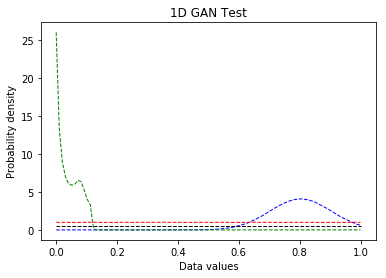

Pre-traning generator for good distribution
('G error=', 0.29048249)
('G error=', 0.00051767653)
('G error=', 0.00032125958)
('G error=', 0.00026746173)
('G error=', 0.00023631964)
('G error=', 0.00021570614)
('G error=', 0.00020067103)
('G error=', 0.00018846446)
('G error=', 0.00017772775)
('G error=', 0.0001678406)


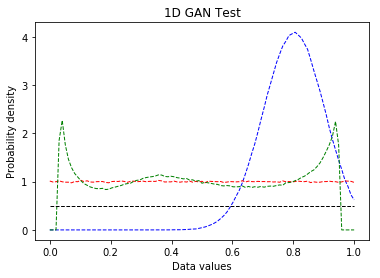

Pre-train Discriminator
0.307368
0.237152
0.10298
0.232237
0.102574
0.230776
0.102184
0.229965
0.101829
0.229214


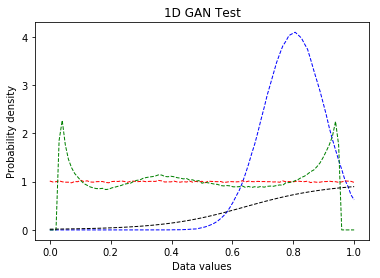

Train Both
(1.6749187, 0.98034418)
(1.0195806, 1.1777495)
(1.240068, 1.0895785)
(1.3049022, 1.0784446)
(1.2843647, 1.1066446)
(1.2244264, 1.1504326)
(1.1326054, 1.2053679)
(1.0129296, 1.2511892)
(0.91122633, 1.2694808)
(0.8428784, 1.2924515)


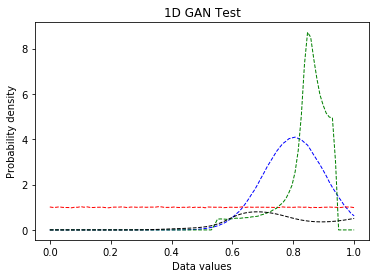

In [10]:
print("Hello! GAN!")
sess.run(tf.global_variables_initializer())
tf.global_variables_initializer().run()
x = np.random.normal(mu,sigma,num_samples)
z = np.random.uniform(0,1,num_samples)
g = np.ndarray(num_samples)

G = GenerativeNetwork()
D = Discriminator()

# sess.run(tf.global_variables_initializer())

# generate data
x_i = np.reshape(x,(num_samples,D.dim_x))
z_i = np.reshape(z,(num_samples,G.dim_z))

sess.run(tf.global_variables_initializer())
g_i = G.generate(z_i)
g = np.reshape(g_i,(num_samples))

d_x_i = np.ndarray(shape=(num_samples,D.dim_x))
d_x_i.fill(1.0)

d_g_i = np.ndarray(shape = (num_samples,D.dim_x))
d_g_i.fill(0.0)

# Not a good way to train.
# TODO: shuffle samples

draw(x,z,g,D)
# GAN algorithm

# Training Generator
D_from_g = D.getNetwork(G.g)    # Discrimination about Generation
loss_g = tf.reduce_mean(-tf.log(D_from_g)) # for D_from_g -> 1
loss_d = tf.reduce_mean(-tf.log(D.d)-tf.log(1-D_from_g)) # for D.d->1 and D_from_g->0

# vars = tf.trainable_variables()
# d_params =[v for v in vars if v.name.startswith('D/')]
# g_params =[v for v in vars if v.name.startswith('G/')]

opt_g = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_g)
opt_d = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_d)


# g_i = G.generate(z_i)
# g = np.reshape(g_i,(num_samples))

# pre-traning generator for good distribution
print("Pre-traning generator for good distribution")
for tr in range(0,1000,1):
    G.train(z_i,z_i) # uniform generation
    if tr % 100 ==0:
        print("G error=",G.train(z_i,z_i))
    
g_i = G.generate(z_i)
g = np.reshape(g_i,(num_samples))
draw(x,z,g,D)

print("Pre-train Discriminator")
for tr in range(0,500,1):
    D.train(x_i,d_x_i)
    D.train(g_i,d_g_i)
    if tr % 100 ==0:
        print(D.train(x_i,d_x_i))
        print(D.train(g_i,d_g_i))
        
draw(x,z,g,D)



print("Train Both")
for tr in range(0,10000,1):
    # generate g from z again to respond the training of Generator
    g_i = G.generate(z_i)
    g = np.reshape(g_i,(num_samples))
    # train Discriminator from real/generated samples
    D.train(x_i,d_x_i)
    D.train(g_i,d_g_i)
    
    # GAN update
    sess.run([loss_g, opt_g],feed_dict={G.z_input:z_i})
    sess.run([loss_d, opt_d],feed_dict={D.x_input:x_i,G.z_input:z_i})
    
    if tr%1000==0:
        error_g,_ = sess.run([loss_g, opt_g],feed_dict={G.z_input:z_i})
        error_d,_ = sess.run([loss_d, opt_d],feed_dict={D.x_input:x_i,G.z_input:z_i})
        print(error_g,error_d)
        
        
# generate g_i again after training Generator
g_i = G.generate(z_i)
g = np.reshape(g_i,(num_samples))
draw(x,z,g,D)